In [1]:
from sklearn.metrics import roc_auc_score
from bids import BIDSLayout
import pandas as pd
import numpy as np
import re
import os

import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
import seaborn as sns
import ptitprince as pt
import dabest

In [2]:
# parse dataset
layout = BIDSLayout('data_bids', validate = False)

# get subjects who completed everything through the SoA scale
sub_ids = layout.get_subjects(task = 'SoAScale')
sub_ids.sort(key = int)

/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


In [3]:
from util.tasks import process_SoAS, process_libet, process_dot_motion

In [4]:
SoAS = process_SoAS(sub_ids, layout)
libet_conds, libet_subs = process_libet(sub_ids, layout)
dot_motion = process_dot_motion(sub_ids, layout)

# remove outliers
libet_subs = libet_subs[~libet_subs.exclude]
dot_motion = dot_motion[~dot_motion.exclude]

In [5]:
data = dabest.load(
    data = libet_conds, 
    x = ['type', 'target'], y = 'estimation error (ms)', 
    id_col = 'subject',
    paired = 'baseline',
    experiment = 'target',
    delta2 = True
)

# visualize distribution of dot motion measurements
ct = pd.DataFrame()
ct['control threshold'] = 100 * dot_motion['control threshold']
ct['type'] = 'percent'
lct = pd.DataFrame()
lct['control threshold'] = dot_motion['log control threshold']
lct['type'] = 'log'
ct_df = pd.concat([ct, lct])

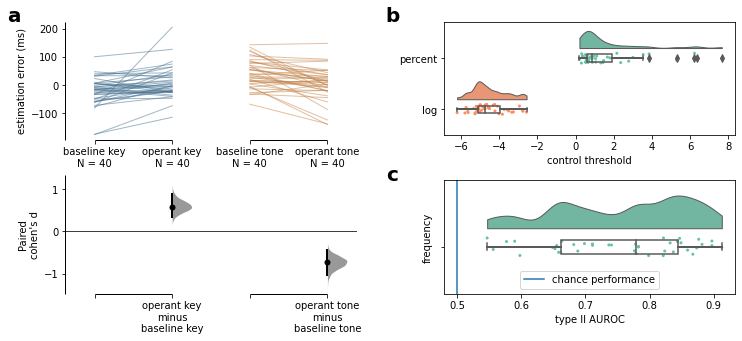

In [6]:
def add_label(ax, label):
    xmin, xmax = ax.get_xlim()
    xscale = xmax - xmin
    ymin, ymax = ax.get_ylim()
    yscale = ymax - ymin
    ax.text(
        xmin - .2 * xscale, ymax, 
        label, size = 20, weight = 'bold'
    )

fig = plt.figure(figsize = (12, 5))
gs = gridspec.GridSpec(2, 2, wspace = .3, hspace = .4)

# visualize intentional binding effect
left_ax = fig.add_subplot(gs[:, 0])
data.cohens_d.plot(es_marker_size = 5, ax = left_ax, show_delta2 = False)
left_ax.get_legend().remove()
add_label(left_ax, 'a')

# visualize distribution of dot motion measurements
ax = fig.add_subplot(gs[0, 1])
pt.RainCloud(x = 'type', y = 'control threshold', data = ct_df, orient = 'h', ax = ax)
ax.set_ylabel(None)
ax.set_xlabel('control threshold')
add_label(ax, 'b')

ax = fig.add_subplot(gs[1, 1])
pt.RainCloud(y = 'AUROC', data = dot_motion, orient = 'h', ax = ax)
ax.set_xlabel('type II AUROC')
ax.set_ylabel('frequency')
ax.axvline(.5, label = 'chance performance')
ax.legend(loc = 'lower center')
add_label(ax, 'c')


plt.show()

In [7]:
# merge sensorimotor measures
merged_sm = libet_subs.merge(dot_motion, how = 'outer', on = 'subject')
# now join agency scores
df = merged_sm.merge(SoAS, how = 'left', on = 'subject')

In [8]:
def get_bootstrap_dist(df, predictor, target):
    from scipy.stats import pearsonr, bootstrap
    corr = lambda x, y: pearsonr(x, y)[0]
    _df = df[[predictor, target]]
    _df = _df[np.isfinite(_df[predictor])]
    res = bootstrap(
        (_df[predictor], _df[target]), corr, 
        method = 'BCa',
        paired = True, vectorized = False,
        n_resamples = 5000
    )
    return res
    
def df_from_res(res, predictor, target):
    x = res.bootstrap_distribution
    df = pd.DataFrame({'correlation': res.bootstrap_distribution})
    df['predictor'] = predictor
    df['target'] = target
    return df

boot_dists = []
df['type II AUROC'] = df['AUROC']
for predictor in ('binding: key', 'binding: tone', 'log control threshold', 'type II AUROC'):
    for target in ('SoPA', 'SoNA'):
        bd = get_bootstrap_dist(df, predictor, target)
        boot_df = df_from_res(bd, predictor, target)
        boot_dists.append(boot_df)
boot_df = pd.concat(boot_dists)

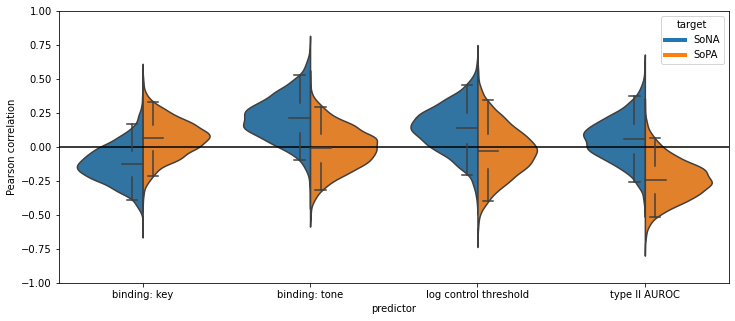

In [9]:
fig, ax = plt.subplots(figsize = (12, 5))
n_pred = boot_df.predictor.unique().size
sns.violinplot(
    data = boot_df,
    x = 'predictor', y = 'correlation', 
    hue = 'target', hue_order = ['SoNA', 'SoPA'],
    split = True, inner = None,
    ax = ax
)
ax.axhline(0., color = 'black', label = 'chance')
ax.set_ylim(-1, 1)

sns.boxplot(
    data = boot_df,
    x = 'predictor', y = 'correlation', 
    hue = 'target', hue_order = ['SoNA', 'SoPA'],
    width = 1./n_pred, fliersize = 0., 
    whis = [2.5, 97.5], # make whiskers 95% confidence interval 
    ax = ax
)
ax.legend_ = None

from matplotlib.lines import Line2D
colors = sns.color_palette()
legend_elements = [
    Line2D([0], [0], color = colors[0], lw = 4, label = 'SoNA'),
    Line2D([0], [0], color = colors[1], lw = 4, label = 'SoPA'),
]
ax.legend(handles = legend_elements, title = 'target')
ax.set_ylabel('Pearson correlation')

plt.show()